In [9]:
#Transfer Learnign Model Keras

from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Dropout, Flatten, Dense
from keras import applications
from keras import backend as K
import numpy as np


Using TensorFlow backend.


In [104]:
img_width, img_height = 224, 224

#top_model_weights_path = 'bottleneck_fc_model.h5'
train_data_dir = '/home/ec2-user/src/Data/ChestXray/chest_xray/train'
validation_data_dir = '/home/ec2-user/src/Data/ChestXray/chest_xray/val'
test_dir = '/home/ec2-user/src/Data/ChestXray/chest_xray/test'
nb_train_samples = 5216
nb_validation_samples = 16
epochs = 5
batch_size = 1
nb_test_samples = 624
test_batch_size = 1


In [105]:
#if K.image_data_format() == 'channels_first':
    #input_shape = (3, img_width, img_height)
#else:
    #input_shape = (img_width, img_height, 3)

In [106]:
model = applications.VGG16(include_top=False, weights='imagenet')
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_8 (InputLayer)         (None, None, None, 3)     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, None, None, 64)    1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, None, None, 64)    36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, None, None, 64)    0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, None, None, 128)   73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, None, None, 128)   147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, None, None, 128)   0         
__________

In [107]:
# reading in image data from training and validation steps 

# use ImageDataGenerator to normalize/augment 

datagen = ImageDataGenerator(rescale=1. / 255)

# use flow_from_directory method to resize/pre-process 

generator = datagen.flow_from_directory(
        train_data_dir,
        target_size=(img_width, img_height),
        batch_size=batch_size,
        class_mode=None,
        shuffle=False)

#use model predict to create bottleneck weights from VGG16 & save to .npy file

bottleneck_features_train = model.predict_generator(
        generator, nb_train_samples // batch_size)
np.save(open('bottleneck_features_train.npy', 'wb'),
            bottleneck_features_train)

generator = datagen.flow_from_directory(
        validation_data_dir,
        target_size=(img_width, img_height),
        batch_size=batch_size,
        class_mode=None,
        shuffle=False)

bottleneck_features_validation = model.predict_generator(
        generator, nb_validation_samples // batch_size)
np.save(open('bottleneck_features_validation.npy', 'wb'), bottleneck_features_validation)

generator = datagen.flow_from_directory(
        test_dir,
        target_size=(img_width, img_height),
        batch_size=batch_size,
        class_mode=None,
        shuffle=False)

bottleneck_features_test = model.predict_generator(
        generator, nb_test_samples // batch_size)
np.save(open('bottleneck_features_test.npy', 'wb'), bottleneck_features_test)



Found 5216 images belonging to 2 classes.
Found 16 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


In [108]:
# train and create labels in sequential order

# Normal 0; Pneumonia 1 

train_data = np.load(open('bottleneck_features_train.npy','rb'))
train_labels = np.array([0] * (1341) + [1] * (3875))

validation_data = np.load(open('bottleneck_features_validation.npy','rb'))
validation_labels = np.array([0] * (8) + [1] * (8))

test_data = np.load(open('bottleneck_features_test.npy','rb'))
test_labels = np.array([0] * (234) + [1] * (390))



In [109]:
print(train_data.shape)
print(train_labels.shape)
print(validation_data.shape)
print(validation_labels.shape)

print(test_data.shape)
print(test_labels.shape)

(5216, 7, 7, 512)
(5216,)
(16, 7, 7, 512)
(16,)
(624, 7, 7, 512)
(624,)


In [110]:
# create dense fully connected model to add to base pre-configured model 
# inputs from trained bottled features

model = Sequential()
model.add(Flatten(input_shape=train_data.shape[1:]))
model.add(Dense(500, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(250, activation='relu'))
model.add(Dropout(0.6))
model.add(Dense(1, activation='sigmoid'))
model.summary()

model.compile(optimizer='Adam', loss='binary_crossentropy', metrics=['accuracy'])


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_8 (Flatten)          (None, 25088)             0         
_________________________________________________________________
dense_17 (Dense)             (None, 500)               12544500  
_________________________________________________________________
dropout_10 (Dropout)         (None, 500)               0         
_________________________________________________________________
dense_18 (Dense)             (None, 250)               125250    
_________________________________________________________________
dropout_11 (Dropout)         (None, 250)               0         
_________________________________________________________________
dense_19 (Dense)             (None, 1)                 251       
Total params: 12,670,001
Trainable params: 12,670,001
Non-trainable params: 0
________________________________________________________________

In [111]:
# fit combined models to data

from keras.callbacks import ModelCheckpoint   

# train the model
checkpointer = ModelCheckpoint(filepath='model.weights.best.hdf5', verbose=1, 
                               save_best_only=True)

predict = model.fit(train_data, train_labels,
             epochs=epochs,
             batch_size=batch_size,
             validation_data=(validation_data, validation_labels), callbacks=[checkpointer], verbose =1)


Train on 5216 samples, validate on 16 samples
Epoch 1/5
5216/5216 [==============================] - 96s - loss: 4.3779 - acc: 0.7176 - val_loss: 7.9712 - val_acc: 0.5000
Epoch 2/5
5216/5216 [==============================] - 95s - loss: 4.1639 - acc: 0.7385 - val_loss: 7.9712 - val_acc: 0.5000
Epoch 3/5
5216/5216 [==============================] - 95s - loss: 4.2141 - acc: 0.7350 - val_loss: 4.9820 - val_acc: 0.6875
Epoch 4/5
5216/5216 [==============================] - 94s - loss: 4.2396 - acc: 0.7331 - val_loss: 7.9712 - val_acc: 0.5000
Epoch 5/5
5216/5216 [==============================] - 94s - loss: 3.9788 - acc: 0.7502 - val_loss: 7.9712 - val_acc: 0.5000


In [112]:
print(predict.history.keys())

dict_keys(['val_acc', 'acc', 'val_loss', 'loss'])


dict_keys(['val_acc', 'acc', 'val_loss', 'loss'])


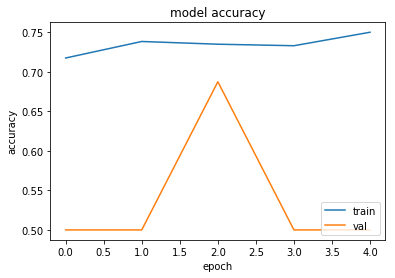

In [113]:
import matplotlib.pyplot as plt
%matplotlib inline

print(predict.history.keys())
plt.plot(predict.history['acc'])
plt.plot(predict.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='lower right')
plt.show()

In [114]:
#load best trained weights

model.load_weights('model.weights.best.hdf5')

In [115]:
# print model accuracy on the test data set

score = model.evaluate(test_data, test_labels, verbose=1)
print('\n', 'Test accuracy:', score[1])


384/624 [=================>............] - ETA: 0s
 Test accuracy: 0.754807692308
